# HYBRID MOVIE RECOMMENDER SYSTEM

A comprehensive implementation combining Collaborative Filtering and Content-Based Filtering
with evaluation metrics and visualizations.

python
Author: Achilles Daralas
Date: April 2025
Dataset: Synthetic MovieLens-like structure (simulated for demonstration)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

## DATA GENERATION

Generate synthetic movie rating data with MovieLens structure.

In [4]:
def generate_movielens_data(n_movies=200, n_users=100, n_ratings=2000):
    genres = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 
              'Crime', 'Documentary', 'Drama', 'Fantasy', 'Horror', 
              'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

    # create movies
    movies_data = []
    for i in range(1, n_movies + 1):
        movie_genres = np.random.choice(genres, size=np.random.randint(1, 4), replace=False)
        movies_data.append({
            'movie_id': i,
            'title': f'Movie_{i}',
            'genres': '|'.join(movie_genres),
            'year': np.random.randint(1980, 2024),
            'popularity': np.random.randint(1, 100)
        })

    movies_df = pd.DataFrame(movies_data)

    # create ratings
    ratings_data = []
    for _ in range(n_ratings):
        user_id = np.random.randint(1, n_users + 1)
        movie_id = np.random.randint(1, n_movies + 1)
        popularity_bias = movies_df[movies_df['movie_id'] == movie_id]['popularity'].values[0] / 100
        base_rating = np.random.normal(3.5, 1.0)
        rating = np.clip(base_rating + popularity_bias, 1, 5)

        ratings_data.append({
            'user_id': user_id,
            'movie_id': movie_id,
            'rating': round(rating),
            'timestamp': np.random.randint(900000000, 1600000000)
        })

    ratings_df = pd.DataFrame(ratings_data)
    ratings_df = ratings_df.drop_duplicates(subset=['user_id', 'movie_id'], keep='first')

    return movies_df, ratings_df

## COLLABORATIVE FILTERING MODEL

**User-based** Collaborative Filtering using cosine similarity.
Predicts ratings based on similar users' preferences.

In [5]:
class CollaborativeFiltering:
    def __init__(self, user_item_matrix):
        self.user_item_matrix = user_item_matrix
        self.user_similarity = None

    def fit(self):
        """Calculate user similarity matrix using cosine similarity"""
        matrix_filled = self.user_item_matrix.replace(0, np.nan)
        self.user_similarity = pd.DataFrame(
            cosine_similarity(matrix_filled.fillna(0)),
            index=self.user_item_matrix.index,
            columns=self.user_item_matrix.index
        )

    def predict(self, user_id, movie_id, k=10):
        """
        Predict rating for a user-movie pair using kNN.

        Parameters:
        -----------
        user_id: int
            User ID
        movie_id: int
            Movie ID
        k: int
            Number of similar users to consider

        Returns:
        --------
        float: Predicted rating (1-5)
        """
        if user_id not in self.user_item_matrix.index:
            return self.user_item_matrix.mean().mean()

        if movie_id not in self.user_item_matrix.columns:
            return self.user_item_matrix.mean().mean()

        movie_ratings = self.user_item_matrix[movie_id]
        rated_users = movie_ratings[movie_ratings > 0].index

        if len(rated_users) == 0:
            return self.user_item_matrix.loc[user_id].mean()

        similarities = self.user_similarity.loc[user_id, rated_users]
        top_k_users = similarities.nlargest(k).index

        ratings = movie_ratings[top_k_users]
        sims = similarities[top_k_users]

        mask = sims > 0
        ratings = ratings[mask]
        sims = sims[mask]

        if len(ratings) == 0:
            return self.user_item_matrix.loc[user_id].mean()

        weighted_sum = (ratings * sims).sum()
        sim_sum = sims.sum()

        if sim_sum == 0:
            return self.user_item_matrix.loc[user_id].mean()

        prediction = weighted_sum / sim_sum
        return np.clip(prediction, 1, 5)

## CONTENT-BASED FILTERING MODEL

Content-Based Filtering using movie genres with TF-IDF.
Predicts ratings based on content similarity.

In [ ]:
class ContentBasedFiltering:
    def __init__(self, movies_df, ratings_df):
        self.movies_df = movies_df
        self.ratings_df = ratings_df
        self.movie_similarity = None
        self.tfidf_matrix = None

    def fit(self):
        """Calculate movie similarity based on genres using TF-IDF"""
        tfidf = TfidfVectorizer(token_pattern=r'[^|]+')
        self.tfidf_matrix = tfidf.fit_transform(self.movies_df['genres'])
        movie_sim_matrix = cosine_similarity(self.tfidf_matrix)

        self.movie_similarity = pd.DataFrame(
            movie_sim_matrix,
            index=self.movies_df['movie_id'],
            columns=self.movies_df['movie_id']
        )

    def get_user_profile(self, user_id):
        """Create user profile based on rating history"""
        user_ratings = self.ratings_df[self.ratings_df['user_id'] == user_id]

        if len(user_ratings) == 0:
            return None

        user_profile = {}
        for _, row in user_ratings.iterrows():
            user_profile[row['movie_id']] = row['rating']

        return user_profile

    def predict(self, user_id, movie_id, k=10):
        """
        Predict rating using content-based approach.

        parameters:
        -----------
        user_id: int
            User ID
        movie_id: int
            Movie ID
        k: int
            Number of similar movies to consider

        returns:
        --------
        float: Predicted rating (1-5)
        """
        user_profile = self.get_user_profile(user_id)

        if user_profile is None or movie_id not in self.movie_similarity.index:
            return 3.0

        similarities = self.movie_similarity.loc[movie_id]

        weighted_sum = 0
        sim_sum = 0

        for rated_movie_id, rating in user_profile.items():
            if rated_movie_id in similarities.index:
                sim = similarities[rated_movie_id]
                weighted_sum += sim * rating
                sim_sum += sim

        if sim_sum == 0:
            return 3.0

        prediction = weighted_sum / sim_sum
        return np.clip(prediction, 1, 5)

## HYBRID RECOMMENDER SYSTEM

Hybrid Recommender combining Collaborative and Content-Based Filtering.
Uses weighted combination approach.

In [8]:
class HybridRecommender:
    def __init__(self, cf_model, cb_model, alpha=0.5):
        """
        parameters:
        -----------
        cf_model: CollaborativeFiltering
            Trained collaborative filtering model
        cb_model: ContentBasedFiltering
            Trained content-based filtering model
        alpha: float (0-1)
            Weight for collaborative filtering
            (1-alpha) is the weight for content-based filtering
        """
        self.cf_model = cf_model
        self.cb_model = cb_model
        self.alpha = alpha

    def predict(self, user_id, movie_id):
        """
        Predict rating using weighted hybrid approach.

        parameters:
        -----------
        user_id: int
            User ID
        movie_id: int
            Movie ID

        returns:
        --------
        float: Predicted rating (1-5)
        """
        cf_pred = self.cf_model.predict(user_id, movie_id)
        cb_pred = self.cb_model.predict(user_id, movie_id)

        hybrid_pred = self.alpha * cf_pred + (1 - self.alpha) * cb_pred
        return np.clip(hybrid_pred, 1, 5)

    def recommend_movies(self, user_id, n_recommendations=10):
        """
        Recommend top N movies for a user.

        parameters:
        -----------
        user_id: int
            User ID
        n_recommendations: int
            Number of movies to recommend

        returns:
        --------
        list: List of recommended movies with predicted ratings
        """
        all_movies = self.cb_model.movies_df['movie_id'].values
        user_ratings = self.cb_model.ratings_df[
            self.cb_model.ratings_df['user_id'] == user_id
        ]['movie_id'].values

        unrated_movies = [m for m in all_movies if m not in user_ratings]

        predictions = []
        for movie_id in unrated_movies:
            pred_rating = self.predict(user_id, movie_id)
            predictions.append((movie_id, pred_rating))

        predictions.sort(key=lambda x: x[1], reverse=True)
        top_recommendations = predictions[:n_recommendations]

        recommendations = []
        for movie_id, pred_rating in top_recommendations:
            movie_info = self.cb_model.movies_df[
                self.cb_model.movies_df['movie_id'] == movie_id
            ].iloc[0]
            recommendations.append({
                'movie_id': movie_id,
                'title': movie_info['title'],
                'genres': movie_info['genres'],
                'predicted_rating': pred_rating
            })

        return recommendations

## EVALUATION

Evaluate a recommender model using RMSE, MAE, and MSE.


In [7]:
def evaluate_model(model, test_data, model_name):
    """
    parameters:
    -----------
    model: RecommenderModel
        Trained model with predict() method
    test_data: DataFrame
        Test dataset with user_id, movie_id, rating columns
    model_name: str
        Name of the model for reporting

    returns:
    --------
    dict: Dictionary containing evaluation metrics
    """
    predictions = []
    actuals = []

    print(f"Evaluating {model_name}...")

    for _, row in test_data.iterrows():
        user_id = row['user_id']
        movie_id = row['movie_id']
        actual_rating = row['rating']

        pred_rating = model.predict(user_id, movie_id)
        predictions.append(pred_rating)
        actuals.append(actual_rating)

    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    mae = mean_absolute_error(actuals, predictions)
    mse = mean_squared_error(actuals, predictions)

    return {
        'model': model_name,
        'rmse': rmse,
        'mae': mae,
        'mse': mse,
        'predictions': predictions,
        'actuals': actuals
    }

def create_user_item_matrix(data):
    """Create user-item rating matrix"""
    matrix = data.pivot_table(
        index='user_id',
        columns='movie_id',
        values='rating',
        fill_value=0
    )
    return matrix

## VISUALIZATION

Plot model performance comparison

In [11]:
def plot_model_comparison(results_list):
    """Plot model performance comparison"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    models = [r['model'] for r in results_list]
    rmse_values = [r['rmse'] for r in results_list]
    mae_values = [r['mae'] for r in results_list]

    # RMSE comparison
    axes[0].bar(models, rmse_values, color='steelblue')
    axes[0].set_xlabel('Model')
    axes[0].set_ylabel('RMSE')
    axes[0].set_title('Model Performance Comparison (RMSE)')
    axes[0].tick_params(axis='x', rotation=45)

    # MAE comparison
    axes[1].bar(models, mae_values, color='coral')
    axes[1].set_xlabel('Model')
    axes[1].set_ylabel('MAE')
    axes[1].set_title('Model Performance Comparison (MAE)')
    axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    print("Model comparison plot saved")

def plot_rating_distribution(ratings_df):
    """Plot rating distribution"""
    plt.figure(figsize=(10, 6))
    ratings_df['rating'].value_counts().sort_index().plot(kind='bar', color='skyblue')
    plt.xlabel('Rating')
    plt.ylabel('Count')
    plt.title('Rating Distribution')
    plt.tight_layout()
    print("Rating distribution plot saved")

## MAIN EXECUTION

HYBRID MOVIE RECOMMENDER SYSTEM

1. Generating data...
Movies: 200, Users: 100, Ratings: 1907

2. Splitting data...
Train: 1525, Test: 382

3. Training models...
   - Collaborative Filtering...
   - Content-Based Filtering...
   - Hybrid Models...

4. Evaluating models...
Evaluating Collaborative Filtering...
Evaluating Content-Based Filtering...
Evaluating Hybrid (Balanced)...
Evaluating Hybrid (CF-Heavy)...
Evaluating Hybrid (CB-Heavy)...

5. Results Summary:

Collaborative Filtering:
RMSE: 1.0680
MAE:  0.8548
MSE:  1.1405

Content-Based Filtering:
RMSE: 1.1457
MAE:  0.9074
MSE:  1.3127

Hybrid (Balanced):
RMSE: 1.0159
MAE:  0.8220
MSE:  1.0320

Hybrid (CF-Heavy):
RMSE: 1.0142
MAE:  0.8214
MSE:  1.0287

Hybrid (CB-Heavy):
RMSE: 1.0476
MAE:  0.8482
MSE:  1.0975

6. Generating visualizations...
Model comparison plot saved
Rating distribution plot saved

7. Sample recommendations for User 1:
1. Movie_186 (Comedy|Mystery|Crime) - Predicted: 4.66
2. Movie_115 (Action) - Predicted: 4.61
3.

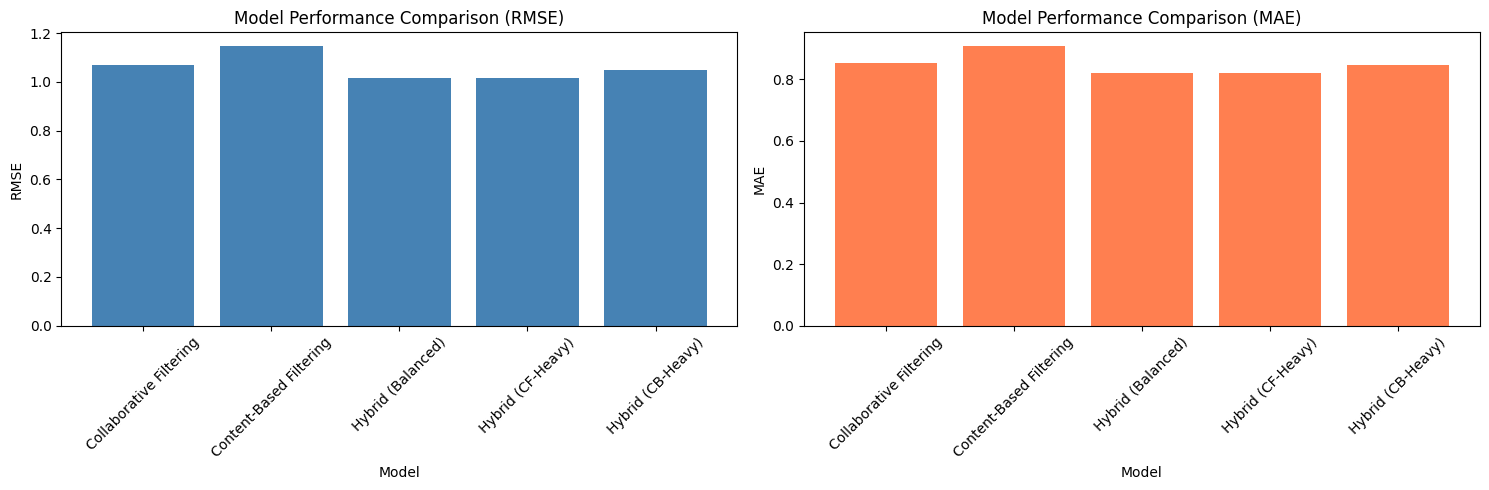

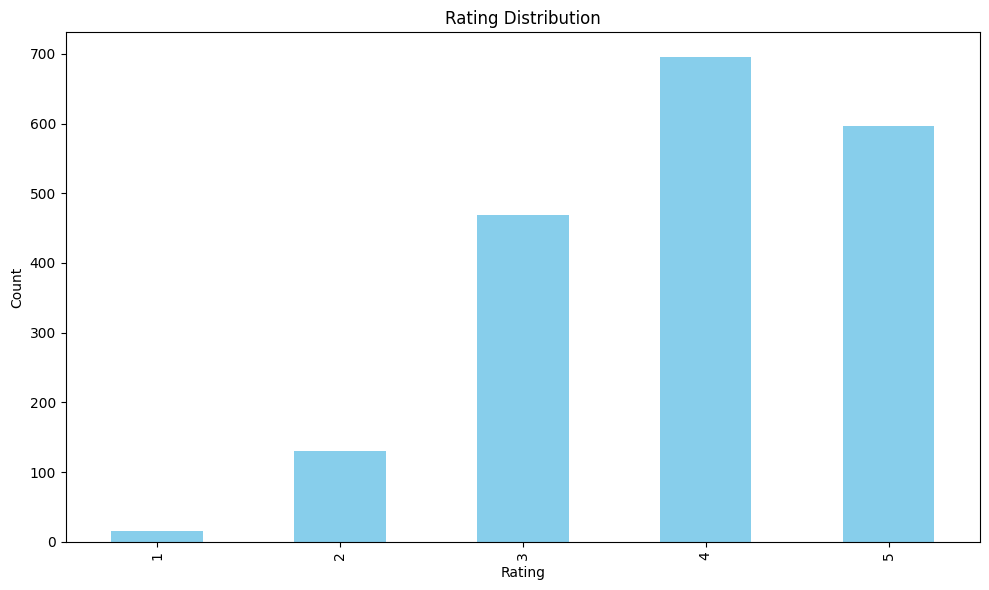

In [12]:
def main():
    """Main execution function"""
    print("="*80)
    print("HYBRID MOVIE RECOMMENDER SYSTEM")
    print("="*80)

    # Step 1: Generate data
    print("\n1. Generating data...")
    movies_df, ratings_df = generate_movielens_data(n_movies=200, n_users=100, n_ratings=2000)
    print(f"Movies: {len(movies_df)}, Users: {ratings_df['user_id'].nunique()}, Ratings: {len(ratings_df)}")

    # Step 2: Split data
    print("\n2. Splitting data...")
    train_data, test_data = train_test_split(ratings_df, test_size=0.2, random_state=42)
    train_matrix = create_user_item_matrix(train_data)
    print(f"Train: {len(train_data)}, Test: {len(test_data)}")

    # Step 3: Train models
    print("\n3. Training models...")

    print("   - Collaborative Filtering...")
    cf_model = CollaborativeFiltering(train_matrix)
    cf_model.fit()

    print("   - Content-Based Filtering...")
    cb_model = ContentBasedFiltering(movies_df, train_data)
    cb_model.fit()

    print("   - Hybrid Models...")
    hybrid_balanced = HybridRecommender(cf_model, cb_model, alpha=0.5)
    hybrid_cf_heavy = HybridRecommender(cf_model, cb_model, alpha=0.7)
    hybrid_cb_heavy = HybridRecommender(cf_model, cb_model, alpha=0.3)

    # Step 4: Evaluate models
    print("\n4. Evaluating models...")
    cf_results = evaluate_model(cf_model, test_data, "Collaborative Filtering")
    cb_results = evaluate_model(cb_model, test_data, "Content-Based Filtering")
    hybrid_bal_results = evaluate_model(hybrid_balanced, test_data, "Hybrid (Balanced)")
    hybrid_cf_results = evaluate_model(hybrid_cf_heavy, test_data, "Hybrid (CF-Heavy)")
    hybrid_cb_results = evaluate_model(hybrid_cb_heavy, test_data, "Hybrid (CB-Heavy)")

    # Step 5: Display results
    print("\n5. Results Summary:")
    print("="*80)
    results_list = [cf_results, cb_results, hybrid_bal_results, hybrid_cf_results, hybrid_cb_results]

    for result in results_list:
        print(f"\n{result['model']}:")
        print(f"RMSE: {result['rmse']:.4f}")
        print(f"MAE:  {result['mae']:.4f}")
        print(f"MSE:  {result['mse']:.4f}")

    # Step 6: Generate visualizations
    print("\n6. Generating visualizations...")
    plot_model_comparison(results_list)
    plot_rating_distribution(ratings_df)

    # Step 7: Generate sample recommendations
    print("\n7. Sample recommendations for User 1:")
    recommendations = hybrid_balanced.recommend_movies(1, n_recommendations=10)
    for i, rec in enumerate(recommendations, 1):
        print(f"{i}. {rec['title']} ({rec['genres']}) - Predicted: {rec['predicted_rating']:.2f}")

    print("\n" + "="*80)
    print("Hybrid Recommender System execution completed!")
    print("="*80)

if __name__ == "__main__":
    main()